In [ ]:
#default_exp data.core

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.load import *
from local.data.transform import *
from local.data.pipeline import *
from local.data.external import *
from local.notebook.showdoc import *

# Helper functions for processing data

> Functions for getting, splitting, and labeling data, etc

## Get, split, and label

For most data source creation we need functions to get a list of items, split them in to train/valid sets, and label them. fastai provides functions to make each of these steps easy (especially when combined with `fastai.data.blocks`).

### Get

First we'll look at functions that *get* a list of items (generally file names).

We'll use *tiny MNIST* (a subset of MNIST with just two classes, `7`s and `3`s) for our examples/tests throughout this page.

In [ ]:
path = untar_data(URLs.MNIST_TINY)
(path/'train').ls()

(#2) [/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3,/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/7]

In [ ]:
# export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [ ]:
# export
def get_files(path, extensions=None, recurse=True, folders=None):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified."
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if folders is not None and i==0: d[:] = [o for o in d if o in folders]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f, extensions)
    return L(res)

This is the most general way to grab a bunch of file names from disk. If you pass `extensions` (including the `.`) then returned file names are filtered by that list. Only those files directly in `path` are included, unless you pass `recurse`, in which case all child folders are also searched recursively. `folders` is an optional list of directories to limit the search to.

In [ ]:
t3 = get_files(path/'train'/'3', extensions='.png', recurse=False)
t7 = get_files(path/'train'/'7', extensions='.png', recurse=False)
t  = get_files(path/'train', extensions='.png', recurse=True)
test_eq(len(t), len(t3)+len(t7))
test_eq(len(get_files(path/'train'/'3', extensions='.jpg', recurse=False)),0)
test_eq(len(t), len(get_files(path, extensions='.png', recurse=True, folders='train')))
t

(#709) [/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3/8055.png,/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3/9466.png,/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3/7778.png,/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3/8824.png,/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3/8228.png,/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3/9620.png,/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3/8790.png,/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3/7497.png,/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3/7383.png,/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3/9324.png...]

In [ ]:
#hide
test_eq(len(get_files(path/'train'/'3', recurse=False)),346)
test_eq(len(get_files(path, extensions='.png', recurse=True, folders=['train', 'test'])),729)

It's often useful to be able to create functions with customized behavior. `fastai.data` generally uses functions named as CamelCase verbs ending in `er` to create these functions. `FileGetter` is a simple example of such a function creator.

In [ ]:
#export
def FileGetter(suf='', extensions=None, recurse=True, folders=None):
    "Create `get_files` partial function that searches path suffix `suf`, only in `folders`, if specified, and passes along args"
    def _inner(o, extensions=extensions, recurse=recurse, folders=folders):
        return get_files(o/suf, extensions, recurse, folders)
    return _inner

In [ ]:
fpng = FileGetter(extensions='.png', recurse=False)
test_eq(len(t7), len(fpng(path/'train'/'7')))
test_eq(len(t), len(fpng(path/'train', recurse=True)))
fpng_r = FileGetter(extensions='.png', recurse=True)
test_eq(len(t), len(fpng_r(path/'train')))

In [ ]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [ ]:
#export
def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)

This is simply `get_files` called with a list of standard image extensions.

In [ ]:
test_eq(len(t), len(get_image_files(path, recurse=True, folders='train')))

In [ ]:
#export
def ImageGetter(suf='', recurse=True, folders=None):
    "Create `get_image_files` partial function that searches path suffix `suf` and passes along `kwargs`, only in `folders`, if specified."
    def _inner(o, recurse=recurse, folders=folders): return get_image_files(o/suf, recurse, folders)
    return _inner

Same as `FileGetter`, but for image extensions.

In [ ]:
test_eq(len(get_files(path/'train', extensions='.png', recurse=True, folders='3')),
        len(ImageGetter(   'train',                    recurse=True, folders='3')(path)))

### Split

The next set of functions are used to *split* data into training and validation sets. The functions return two lists - a list of indices or masks for each of training and validation sets.

In [ ]:
# export
def RandomSplitter(valid_pct=0.2, seed=None, **kwargs):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o, **kwargs):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(int(i) for i in torch.randperm(len(o)))
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner

In [ ]:
src = list(range(30))
f = RandomSplitter(seed=42)
trn,val = f(src)
assert 0<len(trn)<len(src)
assert all(o not in val for o in trn)
test_eq(len(trn), len(src)-len(val))
# test random seed consistency
test_eq(f(src)[0], trn)

In [ ]:
# export
def _grandparent_idxs(items, name): return mask2idxs(Path(o).parent.parent.name == name for o in items)

In [ ]:
# export
def GrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o, **kwargs):
        return _grandparent_idxs(o, train_name),_grandparent_idxs(o, valid_name)
    return _inner

In [ ]:
items = [path/'train/3/9932.png', path/'valid/7/7189.png', 
         path/'valid/7/7320.png', path/'train/7/9833.png',  
         path/'train/3/7666.png', path/'valid/3/925.png',
         path/'train/7/724.png', path/'valid/3/93055.png']
splitter = GrandparentSplitter()
test_eq(splitter(items),[[0,3,4,6],[1,2,5,7]])

### Label

The final set of functions is used to *label* a single item of data.

In [ ]:
# export
def parent_label(o, **kwargs):
    "Label `item` with the parent folder name."
    return o.parent.name if isinstance(o, Path) else o.split(os.path.sep)[-2]

Note that `parent_label` doesn't have anything customize, so it doesn't return a function - you can just use it directly.

In [ ]:
test_eq(parent_label(items[0]), '3')
test_eq(parent_label("fastai_dev/dev/data/mnist_tiny/train/3/9932.png"), '3')
[parent_label(o) for o in items]

['3', '7', '7', '7', '3', '3', '7', '3']

In [ ]:
# export
def RegexLabeller(pat):
    "Label `item` with regex `pat`."
    pat = re.compile(pat)
    def _inner(o, **kwargs):
        res = pat.search(str(o))
        assert res,f'Failed to find "{pat}" in "{o}"'
        return res.group(1)
    return _inner

`RegexLabeller` is a very flexible function since it handles any regex search of the stringified item. For instance, here's an example the replicates the previous `parent_label` results.

In [ ]:
f = RegexLabeller(r'/(\d)/')
test_eq(parent_label(items[0]), '3')
[f(o) for o in items]

['3', '7', '7', '7', '3', '3', '7', '3']

## Categorize -

In [ ]:
#export
class CategoryMap(CollBase):
    def __init__(self, col, sort=True, add_na=False):
        if is_categorical_dtype(col): items = L(col.cat.categories, use_list=True)
        else:
            # `o==o` is the generalized definition of non-NaN used by Pandas
            items = L(o for o in L(col, use_list=True).unique() if o==o)
            if sort: items = items.sorted()
        self.items = '#na#' + items if add_na else items
        self.o2i = defaultdict(int, self.items.val2idx())
    def __eq__(self,b): return all_equal(b,self)

In [ ]:
t = CategoryMap([4,2,3,4])
test_eq(t, [2,3,4])
test_eq(t.o2i, {2:0,3:1,4:2})

In [ ]:
t = CategoryMap([4,2,3,4], add_na=True)
test_eq(t, ['#na#',2,3,4])
test_eq(t.o2i, {'#na#':0,2:1,3:2,4:3})

In [ ]:
t = CategoryMap(pd.Series([4,2,3,4]), sort=False)
test_eq(t, [4,2,3])
test_eq(t.o2i, {4:0,2:1,3:2})

In [ ]:
col = pd.Series(pd.Categorical(['M','H','L','M'], categories=['H','M','L'], ordered=True))
t = CategoryMap(col)
test_eq(t, ['H','M','L'])
test_eq(t.o2i, {'H':0,'M':1,'L':2})

In [ ]:
# export
class Category(str, ShowTitle): _show_args = {'label': 'category'}

In [ ]:
# export
class Categorize(Transform):
    "Reversible transform of category string to `vocab` id"
    order=1
    def __init__(self, vocab=None, add_na=False):
        self.add_na = add_na
        self.vocab = None if vocab is None else CategoryMap(vocab, add_na=add_na)

    def setup(self, dsrc):
        if self.vocab is None and dsrc: self.vocab = CategoryMap(getattr(dsrc,'train',dsrc), add_na=self.add_na)

    def encodes(self, o): return self.vocab.o2i[o]
    def decodes(self, o): return Category(self.vocab[o])

In [ ]:
#export
Category.create = Categorize

In [ ]:
cat = Category.create()
tds = TfmdDS(['cat', 'dog', 'cat'], tfms=[cat])
test_eq(cat.vocab, ['cat', 'dog'])
test_eq(cat('cat'), 0)
test_eq(cat.decode(1), 'dog')
test_stdout(lambda: tds.show_at(2), 'cat')

In [ ]:
cat = Category.create(add_na=True)
tds = TfmdDS(['cat', 'dog', 'cat'], tfms=[cat])
test_eq(cat.vocab, ['#na#', 'cat', 'dog'])
test_eq(cat('cat'), 1)
test_eq(cat.decode(2), 'dog')
test_stdout(lambda: tds.show_at(2), 'cat')

## Multicategorize -

In [ ]:
#export
class MultiCategory(L):
    def show(self, ctx=None, sep=';', **kwargs): return show_title(sep.join(self.mapped(str)), ctx=ctx)

In [ ]:
# export
class MultiCategorize(Categorize):
    "Reversible transform of multi-category strings to `vocab` id"
    def setup(self, dsrc):
        if not dsrc: return
        if self.vocab is None:
            dsrc1 = getattr(dsrc,'train',dsrc)
            vals = set()
            for b in dsrc1: vals = vals.union(set(b))
            self.vocab,self.o2i = uniqueify(list(vals), sort=True, bidir=True)
        setattr(dsrc, 'vocab', self.vocab)

    def encodes(self, o):                return [self.o2i  [o_] for o_ in o]
    def decodes(self, o): return MultiCategory([self.vocab[o_] for o_ in o])

In [ ]:
# export
MultiCategory.create = MultiCategorize

In [ ]:
cat = MultiCategorize()
tds = TfmdDS([['b', 'c'], ['a'], ['a', 'c']], tfms=[cat])
test_eq(cat.vocab, ['a', 'b', 'c'])
test_eq(cat(['a', 'c']), [0,2])
test_eq(cat([]), [])
test_eq(cat.decode([1]), ['b'])
test_eq(cat.decode([0,2]), ['a', 'c'])
test_stdout(lambda: tds.show_at(2), 'a;c')

In [ ]:
# export
class OneHotEncode(Transform):
    "One-hot encodes targets and optionally decodes with `vocab`"
    order=2
    def __init__(self, do_encode=True, vocab=None): self.do_encode,self.vocab = do_encode,vocab

    def setup(self, dsrc):
        if self.vocab is not None:  self.c = len(self.vocab)
        else: self.c = len(L(getattr(dsrc, 'vocab', None)))
        if not self.c: warn("Couldn't infer the number of classes, please pass a `vocab` at init")

    def encodes(self, o): return one_hot(o, self.c) if self.do_encode else tensor(o).byte()
    def decodes(self, o): return one_hot_decode(o, self.vocab)

Work in conjunction with ` MultiCategorize` or on its own if you have one-hot encoded targets (pass a `vocab` for decoding and `do_encode=False` in this case)

In [ ]:
_tfm = OneHotEncode(vocab=['a', 'b', 'c'])
tds = TfmdDS([[1,2], [0], [0, 1]], tfms=[_tfm])
test_eq(_tfm([0,2]), tensor([1, 0, 1]).byte())
test_eq(_tfm.decode(tensor([0,1,1])), ['b','c'])

In [ ]:
_tfm = OneHotEncode(vocab=['a', 'b', 'c'], do_encode=False)
tds = TfmdDS([[0,1,1], [1,0,0], [1,1,0]], tfms=[_tfm])
test_eq(_tfm([1,0,1]), tensor([1, 0, 1]).byte())
test_eq(_tfm.decode(tensor([0,1,1])), ['b','c'])

In [ ]:
tds = TfmdDS([['b', 'c'], ['a'], ['a', 'c']], [[MultiCategorize(), OneHotEncode()]])
test_eq(tds[1], [tensor([1, 0, 0]).byte()])
test_eq(tds.decode([tensor([0,1,1])]), [['b','c']])
test_stdout(lambda: tds.show_at(2), 'a;c')

## End-to-end dataset example with MNIST

In [ ]:
items = get_image_files(path)
splits = splitter(items)
train,valid = (items[i] for i in splits)
train[:3],valid[:3]

([PosixPath('/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3/8055.png'),
  PosixPath('/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3/9466.png'),
  PosixPath('/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3/7778.png')],
 [PosixPath('/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/valid/3/957.png'),
  PosixPath('/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/valid/3/9073.png'),
  PosixPath('/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/valid/3/8939.png')])

In [ ]:
from PIL import Image
def open_img(fn:Path): return Image.open(fn).copy()
def img2tensor(im:Image.Image): return TensorImage(array(im)[None])

tfms = [[open_img, img2tensor],
        [parent_label, Categorize()]]
train_ds = TfmdDS(train, tfms)

In [ ]:
x,y = train_ds[3]
xd,yd = train_ds.decode_at(3)
test_eq(parent_label(train[3]),yd)
test_eq(array(Image.open(train[3])),xd[0])

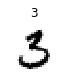

In [ ]:
ax = train_ds.show_at(3, cmap="Greys", figsize=(1,1))

In [ ]:
assert ax.title.get_text() in ('3','7')
test_fig_exists(ax)

## TfmdDL -

In [ ]:
#export
class ToTensor(Transform):
    "Convert item to appropriate tensor class"
    order = 15

In [ ]:
#export
_dl_tfms = ('after_item','before_batch','after_batch')

In [ ]:
#export
@delegates()
class TfmdDL(DataLoader):
    "Transformed `DataLoader`"
    def __init__(self, dataset, bs=16, shuffle=False, num_workers=None, **kwargs):
        if num_workers is None: num_workers = min(16, defaults.cpus)
        for nm in _dl_tfms:
            kwargs[nm] = Pipeline(kwargs.get(nm,None), as_item=(nm=='before_batch'))
            kwargs[nm].setup(self)
        super().__init__(dataset, bs=bs, shuffle=shuffle, num_workers=num_workers, **kwargs)
        it  = self.do_item(0)
        its = self.after_batch(self.do_batch([it]))
        #TODO do we still need?
        self._retain_ds = partial(retain_types, typs=L(it ).mapped(type))
        self._retain_dl = partial(retain_types, typs=L(its).mapped(type))

    def before_iter(self):
        super().before_iter()
        filt = getattr(self.dataset, 'filt', None)
        for nm in _dl_tfms:
            f = getattr(self,nm)
            if isinstance(f,Pipeline): f.filt=filt

    def decode(self, b): return self.before_batch.decode(self.after_batch.decode(self._retain_dl(b)))
    def decode_batch(self, b, max_n=10, ds_decode=True): return self._decode_batch(self.decode(b), max_n, ds_decode)

    def _decode_batch(self, b, max_n=10, ds_decode=True):
        f = compose(self._retain_ds, self.after_item.decode)
        if ds_decode: f = compose(f, getattr(self.dataset,'decode',noop))
        return L(batch_to_samples(b, max_n=max_n)).mapped(f)

    def show_batch(self, b=None, max_n=10, ctxs=None, **kwargs):
        "Show `b` (defaults to `one_batch`), a list of lists of pipeline outputs (i.e. output of a `DataLoader`)"
        if b is None: b = self.one_batch()
        b = self.decode(b)
        if hasattr(b, 'show'): return b.show(max_n=max_n, **kwargs)
        if ctxs is None:
            if hasattr(b[0], 'get_ctxs'): ctxs = b[0].get_ctxs(max_n=max_n, **kwargs)
            else: ctxs = [None] * len(b[0] if is_iter(b[0]) else b)
        db = self._decode_batch(b, max_n, False)
        ctxs = [self.dataset.show(o, ctx=ctx, **kwargs) for o,ctx in zip(db, ctxs)]
        if hasattr(b[0], 'display'): b[0].display(ctxs)

In [ ]:
add_docs(TfmdDL,
         decode="Decode `b` using `tfms`",
         decode_batch="Decode `b` entirely",
         show_batch="Show each item of `b`",
         before_iter="override")

In [ ]:
tfms = [[open_img], [parent_label, Categorize()]]
tds = TfmdDS(items, tfms)
tdl = TfmdDL(tds, after_item=img2tensor, bs=4)
b = tdl.one_batch()
test_eq(L(tdl.decode_batch(b)[0]).mapped(type), (TensorImage,Category))

In [ ]:
class NegTfm(Transform):
    def encodes(self, x): return torch.neg(x)
    def decodes(self, x): return torch.neg(x)
    
tdl = TfmdDL(train_ds, after_batch=NegTfm(), bs=4, num_workers=4)
b = tdl.one_batch()
test_eq(type(b[0]), TensorImage)

In [ ]:
class A(Transform): 
    def encodes(self, x): return x 
    def decodes(self, x): return Int(x) 

@Transform
def f(x)->None: return TupleBase((x,x))

start = torch.arange(50)
test_eq_type(f(2), TupleBase((2,2)))

In [ ]:
tds = TfmdDS(start, [[A()], [f]])
tdl = TfmdDL(tds, bs=4)
x,y = tdl.one_batch()
test_eq(type(y), TupleBase)

s = tdl.decode_batch((x,y))
test_eq(type(s[0][1]), TupleBase)

In [ ]:
tfm = NegTfm(filt=1)
tds = TfmdDS(start, [A()])
tdl = TfmdDL(tds, after_batch=tfm, bs=4)
x = tdl.one_batch()[0]
test_eq(x, torch.arange(4))
tds.filt = 1
x = tdl.one_batch()[0]
test_eq(x, -torch.arange(4))
tds.filt = 0
x = tdl.one_batch()[0]
test_eq(x, torch.arange(4))

In [ ]:
tds = TfmdDS(start, [A()])
tdl = TfmdDL(tds, after_item=NegTfm(), bs=4)
test_stdout(tdl.show_batch, "0\n1\n2\n3")

In [ ]:
tds = TfmdDS(start, [A()])
tdl = TfmdDL(tds, after_batch=NegTfm(), bs=4)
test_eq(*tdl.dataset[0], start[0])
test_eq(len(tdl), (len(tds)-1)//4+1)
test_eq(tdl.bs, 4)

### Methods

In [ ]:
show_doc(TfmdDL.one_batch)

<h4 id="DataLoader.one_batch" class="doc_header"><code>DataLoader.one_batch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01c_dataloader.ipynb#DataLoader" class="source_link" style="float:right">[source]</a></h4>

> <code>DataLoader.one_batch</code>()



In [ ]:
b = tdl.one_batch()
test_eq(tensor([0,-1,-2,-3]), b[0])

In [ ]:
show_doc(TfmdDL.decode)

<h4 id="TfmdDL.decode" class="doc_header"><code>TfmdDL.decode</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/05_data_core.ipynb#TfmdDL--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdDL.decode</code>(**`b`**)

Decode `b` using `tfms`

In [ ]:
test_eq(tdl.decode(b), (tensor(0,1,2,3),))

In [ ]:
show_doc(TfmdDL.decode_batch)

<h4 id="TfmdDL.decode_batch" class="doc_header"><code>TfmdDL.decode_batch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/05_data_core.ipynb#TfmdDL--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdDL.decode_batch</code>(**`b`**, **`max_n`**=*`10`*, **`ds_decode`**=*`True`*)

Decode `b` entirely

In [ ]:
test_eq(tdl.decode_batch(b), ((0,),(1,),(2,),(3,)))

In [ ]:
show_doc(TfmdDL.show_batch)

<h4 id="TfmdDL.show_batch" class="doc_header"><code>TfmdDL.show_batch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/05_data_core.ipynb#TfmdDL--" class="source_link" style="float:right">[source]</a></h4>

> <code>TfmdDL.show_batch</code>(**`b`**=*`None`*, **`max_n`**=*`10`*, **`ctxs`**=*`None`*, **\*\*`kwargs`**)

Show each item of `b`

In [ ]:
test_stdout(tdl.show_batch, "0\n1\n2\n3")

## Cuda -

In [ ]:
# export
@docs
class Cuda(Transform):
    "Move batch to `device` (defaults to `default_device()`)"
    def __init__(self,device=None):
        self.device=default_device() if device is None else device
        super().__init__(filt=None, as_item=False)
    def encodes(self, b): return to_device(b, self.device)
    def decodes(self, b): return to_cpu(b)

    _docs=dict(encodes="Move batch to `device`", decodes="Return batch to CPU")

In [ ]:
show_doc(Cuda.encodes, name='Cuda.encodes')

<h4 id="Cuda.encodes" class="doc_header"><code>Cuda.encodes</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/05_data_core.ipynb#Cuda--" class="source_link" style="float:right">[source]</a></h4>

> <code>Cuda.encodes</code>()

Move batch to [`device`](https://pytorch.org/docs/stable/tensor_attributes.html#torch-device)

Note that, like all `Transform`s, `encodes` is called by `tfm()` and `decodes` is called by `tfm.decode()`.

In [ ]:
tfm = Cuda()
t = tfm((tensor(1),))
test_eq(*t,1)
test_eq(t[0].type(),'torch.cuda.LongTensor' if default_device().type=='cuda' else 'torch.LongTensor')

In [ ]:
show_doc(Cuda.decodes, name='Cuda.decodes')

<h4 id="Cuda.decodes" class="doc_header"><code>Cuda.decodes</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/05_data_core.ipynb#Cuda--" class="source_link" style="float:right">[source]</a></h4>

> <code>Cuda.decodes</code>()

Return batch to CPU

In [ ]:
t = tfm.decode(t)
test_eq(*t,1)
test_eq(t[0].type(),'torch.LongTensor')

## ByteToFloatTensor -

In [ ]:
# export
class ByteToFloatTensor(Transform):
    "Transform image to float tensor, optionally dividing by 255 (e.g. for images)."
    order = 20 #Need to run after CUDA if on the GPU
    def __init__(self, div=True, div_mask=False, filt=None, as_item=True):
        super().__init__(filt=filt,as_item=as_item)
        self.div,self.div_mask = div,div_mask

    def encodes(self, o:TensorImage): return o.float().div_(255.) if self.div else o.float()
    def encodes(self, o:TensorMask ): return o.div_(255.).long() if self.div_mask else o.long()
    def decodes(self, o:TensorImage): return o.clamp(0., 1.) if self.div else o

In [ ]:
t = (TensorImage(tensor(1)),tensor(2).long(),TensorMask(tensor(3)))
tfm = ByteToFloatTensor(as_item=False)
ft = tfm(t)
test_eq(ft, [1./255, 2, 3])
test_eq(type(ft[0]), TensorImage)
test_eq(type(ft[2]), TensorMask)
test_eq(ft[0].type(),'torch.FloatTensor')
test_eq(ft[1].type(),'torch.LongTensor')
test_eq(ft[2].type(),'torch.LongTensor')

## Normalization -

In [ ]:
# export
@docs
class Normalize(Transform):
    "Normalize/denorm batch of `TensorImage`"
    order=99
    def __init__(self, mean, std): self.mean,self.std = mean,std
    def encodes(self, x:TensorImage): return (x-self.mean) / self.std
    def decodes(self, x:TensorImage): return (x*self.std ) + self.mean

    _docs=dict(encodes="Normalize batch", decodes="Denormalize batch")

In [ ]:
# export
def broadcast_vec(dim, ndim, *t, cuda=True):
    "Make a vector broadcastable over `dim` (out of `ndim` total) by prepending and appending unit axes"
    v = [1]*ndim
    v[dim] = -1
    f = to_device if cuda else noop
    return [f(tensor(o).view(*v)) for o in t]

In [ ]:
mean,std = [0.5]*3,[0.5]*3
mean,std = broadcast_vec(1, 4, mean, std)
dl_tfms = [Cuda(), ByteToFloatTensor(), Normalize(mean,std)]
tdl = TfmdDL(train_ds, after_batch=dl_tfms, bs=4)

In [ ]:
x,y  = tdl.one_batch()
xd,yd = tdl.after_batch.decode((x,y))

test_eq(x.type(), 'torch.cuda.FloatTensor')
test_eq(xd.type(), 'torch.FloatTensor')
assert x.mean()<0.0
assert x.std()>0.5
assert 0<xd.mean()/255.<1
assert 0<xd.std()/255.<0.5

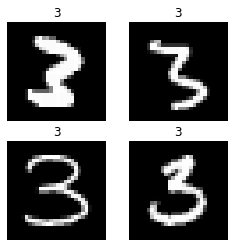

In [ ]:
tdl.show_batch((x,y), figsize=(4,4))

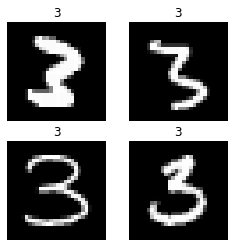

In [ ]:
x,y = torch.add(x,0),torch.add(y,0) #Lose type of tensors (to emulate predictions)
test_ne(type(x), TensorImage)
tdl.show_batch((x,y), figsize=(4,4)) #Check that types are put back by dl.

In [ ]:
#TODO: make the above check a proper test

## DataBunch -

In [ ]:
# export
@docs
class DataBunch(GetAttr):
    "Basic wrapper around several `DataLoader`s."
    _xtra = 'one_batch show_batch dataset'.split()

    def __init__(self, *dls): self.dls,self.default = dls,dls[0]
    def __getitem__(self, i): return self.dls[i]

    train_dl,valid_dl = add_props(lambda i,x: x[i])
    train_ds,valid_ds = add_props(lambda i,x: x[i].dataset)

    _docs=dict(__getitem__="Retrieve `DataLoader` at `i` (`0` is training, `1` is validation)",
              train_dl="Training `DataLoader`",
              valid_dl="Validation `DataLoader`",
              train_ds="Training `Dataset`",
              valid_ds="Validation `Dataset`")

In [ ]:
dbch = DataBunch(tdl,tdl)
x,y  = dbch.train_dl.one_batch()
x2,y2 = next(iter(tdl))
test_eq(x,x2)
x2,y2 = dbch.one_batch()
test_eq(x,x2)

### Methods

In [ ]:
show_doc(DataBunch.__getitem__)

<h4 id="DataBunch.__getitem__" class="doc_header"><code>DataBunch.__getitem__</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/05_data_core.ipynb#DataBunch--" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBunch.__getitem__</code>(**`i`**)

Retrieve [`DataLoader`](/dataloader.html#DataLoader) at `i` (`0` is training, `1` is validation)

In [ ]:
x2,y2 = dbch[0].one_batch()
test_eq(x,x2)

In [ ]:
show_doc(DataBunch.train_dl, name="train_dl")

<h4 id="train_dl" class="doc_header"><code>train_dl</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Training [`DataLoader`](/dataloader.html#DataLoader)

In [ ]:
show_doc(DataBunch.valid_dl, name="valid_dl")

<h4 id="valid_dl" class="doc_header"><code>valid_dl</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Validation [`DataLoader`](/dataloader.html#DataLoader)

In [ ]:
show_doc(DataBunch.train_ds, name="train_ds")

<h4 id="train_ds" class="doc_header"><code>train_ds</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Training `Dataset`

In [ ]:
show_doc(DataBunch.valid_ds, name="valid_ds")

<h4 id="valid_ds" class="doc_header"><code>valid_ds</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Validation `Dataset`

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_torch_core.ipynb.
Converted 01b_script.ipynb.
